In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
data_train = pd.read_csv('kh_char_train.csv', header=None, na_filter=False)
data_test = pd.read_csv('kh_char_test.csv', header=None, na_filter=False)

# Data Preprocessing

In [4]:
x_train = data_train.iloc[:, 1:].to_numpy().astype(float)
y_train = data_train.iloc[:, 0].to_list()
x_test = data_test.iloc[:, 1:].to_numpy().astype(float)
y_test = data_test.iloc[:, 0].to_list()

In [5]:
class KhmerCharacterDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Convert tensor to numpy, reshape, and cast to float
        image = self.data[idx].numpy().reshape(48, 48).astype(float)
        label = self.labels[idx]

        if self.transform:
            # Apply transformation (PIL -> Tensor in transform pipeline)
            image = Image.fromarray(image.astype('uint8'))  # Convert to PIL Image
            image = self.transform(image)

        return image, label


In [6]:
categories = ['CHA', 'CHHA', 'CHHO', 'DA', 'KHA', 'KHO', 'KO', 'NA', 'NGO', 'TA']
mapping = {cat: i + 1 for i, cat in enumerate(categories)}


In [7]:
print(f"Unique train labels: {set(y_train)}")
print(f"Unique test labels: {set(y_test)}")

Unique train labels: {'KHO', 'CHHA', 'KHA', 'DA', 'KO', 'CHA', 'NGO', 'CHHO', 'NA', 'TA'}
Unique test labels: {'TA', 'KHO', 'KHA', 'DA', 'KO', 'CHA', 'NGO', 'CHHO', 'NA', 'CHHA'}


In [8]:
print("Mapping:", mapping)
print("y_train:", y_train[:10])
print("y_test:", y_test[:10])

Mapping: {'CHA': 1, 'CHHA': 2, 'CHHO': 3, 'DA': 4, 'KHA': 5, 'KHO': 6, 'KO': 7, 'NA': 8, 'NGO': 9, 'TA': 10}
y_train: ['CHHO', 'TA', 'NGO', 'KO', 'NGO', 'TA', 'TA', 'TA', 'TA', 'KHA']
y_test: ['TA', 'NA', 'CHA', 'CHA', 'KHA', 'CHA', 'TA', 'CHHA', 'NGO', 'NGO']


In [9]:
label_encoder = LabelEncoder()

# Convert data to tensors
tx_train = torch.tensor(x_train, dtype=torch.float32)
tx_test = torch.tensor(x_test, dtype=torch.float32)
ty_train = torch.tensor(label_encoder.fit_transform(y_train), dtype=torch.long)
ty_test = torch.tensor(label_encoder.transform(y_test), dtype=torch.long)

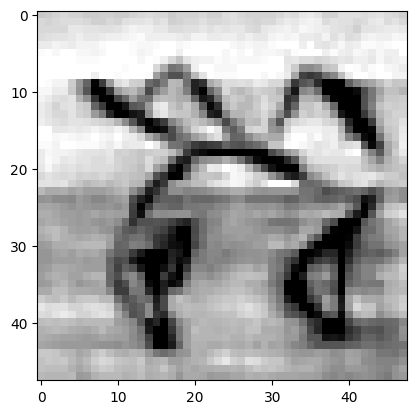

In [10]:
x_0 = x_train[3]
x_0.reshape(48, 48)
plt.imshow(x_0.reshape(48, 48), cmap='gray')

## Tranformation

In [11]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure grayscale (1 channel)
    transforms.Resize((32, 32)),                  # Resize to 32x32
    transforms.ToTensor(),                        # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])   # Normalize for 1 channel
])


# Data Laoder

In [12]:
# Create datasets with transform
train_dataset = KhmerCharacterDataset(tx_train, ty_train, transform=transform)
test_dataset = KhmerCharacterDataset(tx_test, ty_test, transform=transform)

In [13]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [14]:
for images, labels in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

Image batch shape: torch.Size([32, 1, 32, 32])
Label batch shape: torch.Size([32])


In [15]:
print("train_laoder size:", len(train_loader))
print("test_laoder size:", len(test_loader))

train_laoder size: 542
test_laoder size: 434


# Model Architecture

### LeNet Architecture

In [16]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [17]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to GPU if available
model = LeNet().to(device)

Using device: cuda


In [18]:
# Initialize tracking variables for the best epoch
best_epoch_accuracy = 0
best_epoch = 0
best_model_state = None

# Define the loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # lr is the learning rate
num_epochs = 20

# Declare variables to store loss and accuracy for each epoch
train_losses = []
train_accuracies = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        # Move images and labels to the device (GPU or CPU)
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    avg_loss = epoch_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    # Store the loss and accuracy for this epoch
    train_losses.append(avg_loss)
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

    # Track the best epoch
    if epoch_accuracy > best_epoch_accuracy:
        best_epoch_accuracy = epoch_accuracy
        best_epoch = epoch + 1
        best_model_state = model.state_dict()
        print(f"New best epoch: {best_epoch} with accuracy {best_epoch_accuracy:.2f}%. Model state saved.")


Epoch [1/20], Average Loss: 0.6233, Accuracy: 78.67%
New best epoch: 1 with accuracy 78.67%. Model state saved.
Epoch [2/20], Average Loss: 0.2303, Accuracy: 91.51%
New best epoch: 2 with accuracy 91.51%. Model state saved.
Epoch [3/20], Average Loss: 0.1691, Accuracy: 93.70%
New best epoch: 3 with accuracy 93.70%. Model state saved.
Epoch [4/20], Average Loss: 0.1334, Accuracy: 95.16%
New best epoch: 4 with accuracy 95.16%. Model state saved.
Epoch [5/20], Average Loss: 0.1091, Accuracy: 96.00%
New best epoch: 5 with accuracy 96.00%. Model state saved.
Epoch [6/20], Average Loss: 0.0902, Accuracy: 96.74%
New best epoch: 6 with accuracy 96.74%. Model state saved.
Epoch [7/20], Average Loss: 0.0781, Accuracy: 97.17%
New best epoch: 7 with accuracy 97.17%. Model state saved.
Epoch [8/20], Average Loss: 0.0647, Accuracy: 97.63%
New best epoch: 8 with accuracy 97.63%. Model state saved.
Epoch [9/20], Average Loss: 0.0552, Accuracy: 98.08%
New best epoch: 9 with accuracy 98.08%. Model state

In [19]:
# Save the best model state to a file
if best_model_state:
    torch.save(best_model_state, "best_epoch_model.pth")
    print(f"Best epoch model saved to 'best_epoch_model.pth'. Epoch: {best_epoch}, Accuracy: {best_epoch_accuracy:.2f}%")

Best epoch model saved to 'best_epoch_model.pth'. Epoch: 18, Accuracy: 99.69%


In [20]:
# Load the best model for evaluation
model.load_state_dict(torch.load("best_epoch_model.pth"))
model.eval()

C:\Users\Asus-PC\AppData\Local\Temp\ipykernel_17872\3577885849.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_epoch_model.pth"))


LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

## Evaluate the model

In [21]:
# Declare variables to store test loss and accuracy
test_losses = []
test_accuracies = []

# Evaluate on the test dataset
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

# Store the test loss and accuracy
test_losses.append(avg_test_loss)
test_accuracies.append(test_accuracy)

print(f"Test Average Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Average Loss: 0.2622, Test Accuracy: 94.73%


# Training VS Testing loss and accuracy

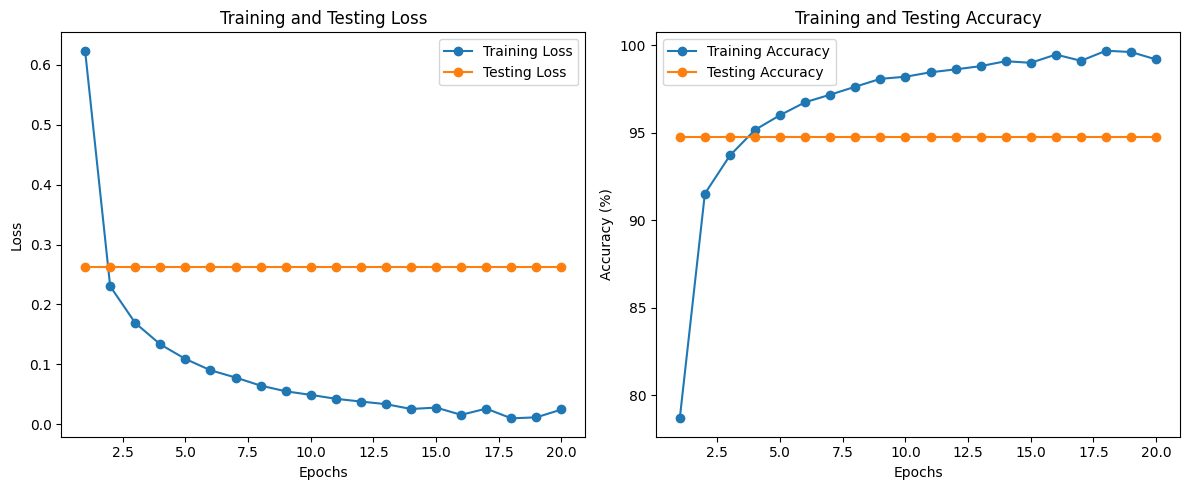

In [22]:
# Number of epochs
epochs = range(1, len(train_losses) + 1)

# Plotting the training and testing loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Training Loss", marker='o')
# The following line has been modified to repeat test_losses value to match the length of epochs
plt.plot(epochs, [test_losses[0]] * len(epochs), label="Testing Loss", marker='o')
plt.title("Training and Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plotting the training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Training Accuracy", marker='o')
# The following line has been modified to repeat test_accuracies value to match the length of epochs
plt.plot(epochs, [test_accuracies[0]] * len(epochs), label="Testing Accuracy", marker='o')
plt.title("Training and Testing Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

## Evaluate by Confusion Matrix

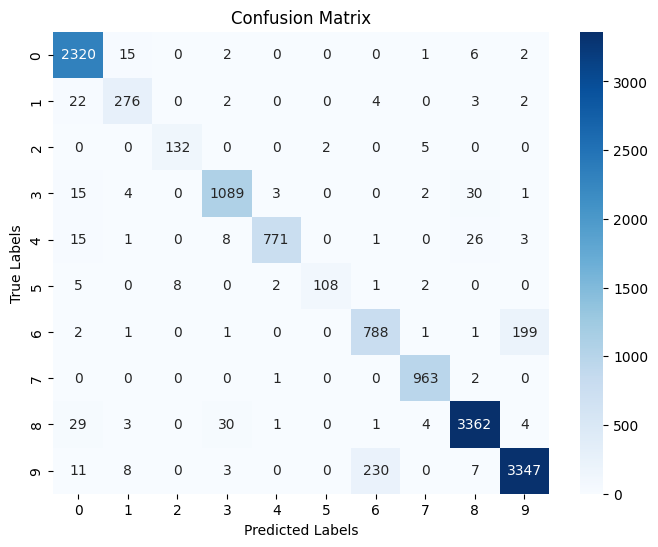

In [25]:
# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Evaluate on the test dataset
with torch.no_grad():
    for images, labels in test_loader:
        # Move images and labels to the device
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


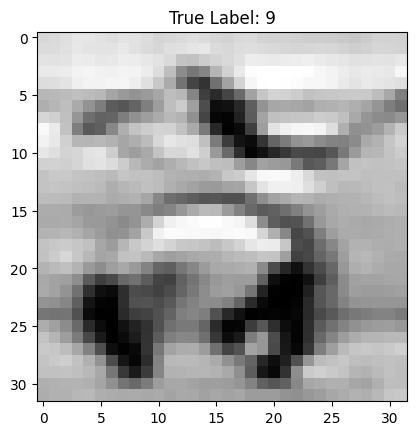

Predicted Label: 9


In [26]:
import matplotlib.pyplot as plt

# Example: Retrieving the first image from the test_loader
dataiter = iter(test_loader)
images, labels = next(dataiter)  # Get one batch of images and labels

# Take the first image from the batch (grayscale image)
single_image = images[0].unsqueeze(0).to(device)  # Add batch dimension and move to device
single_label = labels[0].item()

# Display the grayscale image
plt.imshow(single_image.cpu().squeeze(), cmap='gray')  # Squeeze removes the channel dimension
plt.title(f"True Label: {single_label}")
plt.show()

# Make prediction on this single image
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    output = model(single_image)  # Forward pass for prediction
    _, predicted_label = torch.max(output, 1)  # Get the predicted label

# Print the result
print(f"Predicted Label: {predicted_label.item()}")
